In [1]:
!pip install -q CoolProp rdkit scikit-learn tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen
import pickle
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize, differential_evolution
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 41.2 MB/s eta 0:00:00


In [2]:
MODEL_PATH = '/content/vm_final.keras'
SCALER_PATH = '/content/vm_final.pkl'
try:
    model = keras.models.load_model(MODEL_PATH)
    print("✓ Model loaded successfully")
    with open(SCALER_PATH, 'rb') as f:
        scaler_data = pickle.load(f)
    scalerX = scaler_data['scaler_X']
    scalery = scaler_data['scaler_y']
    feature_cols = scaler_data['feature_cols']

    print("✓ Scalers loaded successfully")
    print(f"✓ Feature columns ({len(feature_cols)}): {feature_cols}")
except Exception as e:
    print(f"ERROR loading model/scalers: {e}")

✓ Model loaded successfully
✓ Scalers loaded successfully
✓ Feature columns (17): ['T', 'P', 'MW', 'LogP', 'HBA', 'HBD', 'RotBonds', 'Rings', 'TPSA', 'NumAtoms', 'NumHeavyAtoms', 'NumHeteroatoms', 'MolWt2', 'Refractivity', 'Tc', 'Pc', 'Vc']


In [3]:
SMILES_DICT = {
    'Water': 'O',
    'Methanol': 'CO',
    'Ethanol': 'CCO',
    'Propanol': 'CCCO',
    'Butanol': 'CCCCO',
    'Ethane': 'CC',
    'Propane': 'CCC',
    'Butane': 'CCCC',
    'Pentane': 'CCCCC',
    'Hexane': 'CCCCCC',
    'Heptane': 'CCCCCCC',
    'Octane': 'CCCCCCCC',
    'Benzene': 'c1ccccc1',
    'Toluene': 'Cc1ccccc1',
    'Xylene': 'Cc1ccccc1C',
    'Acetone': 'CC(=O)C',
    'Ammonia': 'N',
    'Ethylene': 'C=C',
    'Propylene': 'CC=C',
    'Cyclopentane': 'C1CCCC1',
    'Cyclohexane': 'C1CCCCC1',
    'R134a': 'FC(F)C(F)F',
    'R245fa': 'CC(F)(F)C(F)(F)F',
    'Isopentane': 'CC(C)CC',
    'Neopentane': 'CC(C)(C)C',
}
def get_descriptors(smiles):
    """Calculate 12 RDKit molecular descriptors from SMILES"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return {
            'MW': Descriptors.MolWt(mol),
            'LogP': Crippen.MolLogP(mol),
            'HBA': Descriptors.NumHAcceptors(mol),
            'HBD': Descriptors.NumHDonors(mol),
            'RotBonds': Descriptors.NumRotatableBonds(mol),
            'Rings': Descriptors.RingCount(mol),
            'TPSA': Descriptors.TPSA(mol),
            'NumAtoms': mol.GetNumAtoms(),
            'NumHeavyAtoms': Descriptors.HeavyAtomCount(mol),
            'NumHeteroatoms': Descriptors.NumHeteroatoms(mol),
            'MolWt2': Descriptors.ExactMolWt(mol),
            'Refractivity': Crippen.MolMR(mol),
        }
    except:
        return None
def get_critical_properties(fluid_name):
    """Get critical properties from CoolProp"""
    try:
        Tc = PropsSI('Tcrit', fluid_name)
        Pc = PropsSI('pcrit', fluid_name)
        M = PropsSI('M', fluid_name)
        rhoc = PropsSI('rhocrit', fluid_name)
        Vc = M / rhoc * 1e6  # cm³/mol
        return {'Tc': Tc, 'Pc': Pc, 'Vc': Vc, 'M': M}
    except:
        return None

In [4]:
def predict_vm_liquid(fluid_name, T, P, verbose=True):
    """
    Predict liquid molar volume using ML model

    Args:
        fluid_name: Name of fluid (must be in SMILES_DICT)
        T: Temperature (K)
        P: Pressure (Pa)
        verbose: Print MODEL USED message

    Returns:
        Vm in cm³/mol or None if prediction fails
    """
    smiles = SMILES_DICT.get(fluid_name)
    if smiles is None:
        if verbose:
            print(f"✗ ERROR: {fluid_name} not in SMILES_DICT")
        return None
    desc = get_descriptors(smiles)
    if desc is None:
        if verbose:
            print(f"    ✗ ERROR: Could not compute descriptors")
        return None
    crit = get_critical_properties(fluid_name)
    if crit is None:
        if verbose:
            print(f"    ✗ ERROR: Could not get critical properties")
        return None
    rdkit_desc = list(desc.values())
    X = np.array([[T, P] + rdkit_desc + [crit['Tc'], crit['Pc'], crit['Vc']]])
    X_scaled = scalerX.transform(X)
    Vm_scaled = model.predict(X_scaled, verbose=0)
    Vm = scalery.inverse_transform(Vm_scaled)[0, 0]
    if verbose:
        print(f"MODEL USED: Predicted Vm = {Vm:.4f} cm³/mol at T={T:.2f}K, P={P/1e5:.3f}bar")
    return Vm
print("✓ ML model prediction function defined")
def get_liquid_properties_maxwell(fluid_name, T, P, reference='low_pressure'):
    print(f"    Liquid Properties via ML + Maxwell: T={T:.2f}K, P={P/1e5:.2f}bar")
    print(f"    {'─'*50}")
    M = PropsSI('M', fluid_name)
    Vm_cm3 = predict_vm_liquid(fluid_name, T, P, verbose=True)
    if Vm_cm3 is None:
        return None
    Vm_m3 = Vm_cm3 * 1e-6
    v = Vm_m3 / M
    dT = 1.0
    print(f"    Computing (∂V/∂T)_P numerically...")
    Vm_plus = predict_vm_liquid(fluid_name, T + dT, P, verbose=False)
    Vm_minus = predict_vm_liquid(fluid_name, T - dT, P, verbose=False)
    if Vm_plus is None or Vm_minus is None:
        print(f"    ✗ ERROR: Cannot compute temperature derivative")
        return None
    dVm_dT = (Vm_plus - Vm_minus) / (2 * dT)
    dv_dT = (dVm_dT * 1e-6) / M
    print(f"MODEL USED: Computed (∂V/∂T)_P = {dv_dT:.6e} m³/(kg·K)")
    P_ref = 1.0e5
    try:
        h_ref = PropsSI('H', 'T', T, 'P', P_ref, fluid_name)  # J/kg
        s_ref = PropsSI('S', 'T', T, 'P', P_ref, fluid_name)  # J/kg-K
        print(f"    ✓ Reference (T={T:.2f}K, P={P_ref/1e5:.2f}bar): h={h_ref/1000:.2f} kJ/kg, s={s_ref/1000:.4f} kJ/kg-K")
    except:
        try:
            P_sat = PropsSI('P', 'T', T, 'Q', 0, fluid_name)
            h_ref = PropsSI('H', 'T', T, 'Q', 0, fluid_name)
            s_ref = PropsSI('S', 'T', T, 'Q', 0, fluid_name)
            P_ref = P_sat
            print(f"    ✓ Reference (saturation at T={T:.2f}K): P={P_ref/1e5:.3f}bar, h={h_ref/1000:.2f} kJ/kg")
        except:
            print(f"    ✗ ERROR: Cannot get reference properties at T={T:.2f}K")
            return None
    delta_P = P - P_ref
    if abs(delta_P) > 5e5:
        n_steps = 100
        P_array = np.linspace(P_ref, P, n_steps)
        h_integral = 0
        s_integral = 0
        for i in range(n_steps - 1):
            P_mid = (P_array[i] + P_array[i+1]) / 2
            dP_step = P_array[i+1] - P_array[i]
            Vm_mid = predict_vm_liquid(fluid_name, T, P_mid, verbose=False)
            if Vm_mid is None:
                continue
            v_mid = (Vm_mid * 1e-6) / M
            h_integral += (v_mid - T * dv_dT) * dP_step
            s_integral += -dv_dT * dP_step
        h_correction = h_integral
        s_correction = s_integral
        print(f"    ✓ Integrated over {n_steps} steps")
    else:
        h_correction = (v - T * dv_dT) * delta_P
        s_correction = -dv_dT * delta_P
    h = h_ref + h_correction
    s = s_ref + s_correction
    print(f"Maxwell corrections: Δh={h_correction/1000:.3f} kJ/kg, Δs={s_correction/1000:.6f} kJ/kg-K")
    print(f"Final properties: h={h/1000:.2f} kJ/kg, s={s/1000:.4f} kJ/kg-K, v={v:.6e} m³/kg")
    print(f"    {'─'*50}")
    return {
        'h': h,  # J/kg
        's': s,  # J/kg-K
        'v': v,  # m³/kg
        'Vm': Vm_cm3,  # cm³/mol
        'dv_dT': dv_dT,  # m³/(kg·K)
    }
print("Maxwell relations function defined (CORRECTED with proper reference state)")

✓ ML model prediction function defined
Maxwell relations function defined (CORRECTED with proper reference state)


In [5]:
def get_gas_properties_coolprop(fluid_name, T, P):
    try:
        h = PropsSI('H', 'T', T, 'P', P, fluid_name)
        s = PropsSI('S', 'T', T, 'P', P, fluid_name)
        rho = PropsSI('D', 'T', T, 'P', P, fluid_name)
        v = 1 / rho
        print(f"CoolProp (gas): h={h/1000:.2f} kJ/kg, s={s/1000:.4f} kJ/kg-K")
        return {'h': h, 's': s, 'v': v}
    except Exception as e:
        print(f"CoolProp error: {e}")
        return None
def get_saturation_properties(fluid_name, T=None, P=None):
    try:
        if T is not None:
            P_sat = PropsSI('P', 'T', T, 'Q', 0, fluid_name)
            h_f = PropsSI('H', 'T', T, 'Q', 0, fluid_name)
            h_g = PropsSI('H', 'T', T, 'Q', 1, fluid_name)
            s_f = PropsSI('S', 'T', T, 'Q', 0, fluid_name)
            s_g = PropsSI('S', 'T', T, 'Q', 1, fluid_name)
            v_f = 1 / PropsSI('D', 'T', T, 'Q', 0, fluid_name)
            v_g = 1 / PropsSI('D', 'T', T, 'Q', 1, fluid_name)
            return {
                'T_sat': T,
                'P_sat': P_sat,
                'h_f': h_f, 'h_g': h_g, 'h_fg': h_g - h_f,
                's_f': s_f, 's_g': s_g, 's_fg': s_g - s_f,
                'v_f': v_f, 'v_g': v_g
            }
        elif P is not None:
            T_sat = PropsSI('T', 'P', P, 'Q', 0, fluid_name)
            h_f = PropsSI('H', 'P', P, 'Q', 0, fluid_name)
            h_g = PropsSI('H', 'P', P, 'Q', 1, fluid_name)
            s_f = PropsSI('S', 'P', P, 'Q', 0, fluid_name)
            s_g = PropsSI('S', 'P', P, 'Q', 1, fluid_name)
            v_f = 1 / PropsSI('D', 'P', P, 'Q', 0, fluid_name)
            v_g = 1 / PropsSI('D', 'P', P, 'Q', 1, fluid_name)
            return {
                'T_sat': T_sat,
                'P_sat': P,
                'h_f': h_f, 'h_g': h_g, 'h_fg': h_g - h_f,
                's_f': s_f, 's_g': s_g, 's_fg': s_g - s_f,
                'v_f': v_f, 'v_g': v_g
            }
    except Exception as e:
        return None
print("CoolProp gas phase functions defined")

CoolProp gas phase functions defined


In [6]:
def rankine_cycle_simulation(fluid_name, P_evap, P_cond, verbose=True):
    if verbose:
        print("\n" + "="*80)
        print(f"RANKINE CYCLE SIMULATION - {fluid_name}")
        print("="*80)
        print(f"Method: ML Model + Maxwell (liquid), CoolProp (gas)")
        print("="*80)

    try:
        sat_evap = get_saturation_properties(fluid_name, P=P_evap)
        sat_cond = get_saturation_properties(fluid_name, P=P_cond)
        if sat_evap is None or sat_cond is None:
            print("✗ ERROR: Could not get saturation properties")
            return None
        T_evap = sat_evap['T_sat']
        T_cond = sat_cond['T_sat']
        if verbose:
            print(f"\nOperating Conditions:")
            print(f"  Evaporator: P={P_evap/1e5:.2f} bar → T_sat={T_evap:.2f} K ({T_evap-273.15:.1f}°C)")
            print(f"  Condenser:  P={P_cond/1e5:.2f} bar → T_sat={T_cond:.2f} K ({T_cond-273.15:.1f}°C)")
        print(f"\n{'═'*80}")
        print(f"STATE 1: Saturated Liquid at Condenser Exit")
        print(f"P₁={P_cond/1e5:.2f} bar, T₁={T_cond:.2f} K")
        print(f"{'═'*80}")
        h1 = sat_cond['h_f']
        s1 = sat_cond['s_f']
        v1 = sat_cond['v_f']
        print(f"CoolProp (saturation): h₁={h1/1000:.2f} kJ/kg, s₁={s1/1000:.4f} kJ/kg-K")
        print(f"Specific volume: v₁={v1:.6e} m³/kg")
        print(f"\n{'═'*80}")
        print(f"STATE 2: Compressed Liquid at Pump Exit")
        print(f"P₂={P_evap/1e5:.2f} bar, T₂≈{T_cond:.2f} K (isentropic pump)")
        print(f"{'═'*80}")
        w_pump = v1 * (P_evap - P_cond)  # J/kg
        print(f"Pump work: W_pump = v₁ × ΔP = {w_pump/1000:.3f} kJ/kg")
        h2 = h1 + w_pump
        s2 = s1
        T2 = T_cond
        props_2_ml = get_liquid_properties_maxwell(fluid_name, T2, P_evap)
        if props_2_ml:
            print(f"Verification:")
            print(f"- From pump work: h₂={h2/1000:.2f} kJ/kg")
            print(f"- From ML+Maxwell: h₂={props_2_ml['h']/1000:.2f} kJ/kg")
            print(f"- Difference: {abs(h2-props_2_ml['h'])/1000:.2f} kJ/kg")

        print(f"Final State 2: h₂={h2/1000:.2f} kJ/kg, s₂={s2/1000:.4f} kJ/kg-K")
        print(f"\n{'═'*80}")
        print(f"STATE 3: Saturated Vapor at Evaporator Exit")
        print(f"P₃={P_evap/1e5:.2f} bar, T₃={T_evap:.2f} K")
        print(f"{'═'*80}")
        h3 = sat_evap['h_g']
        s3 = sat_evap['s_g']
        v3 = sat_evap['v_g']
        print(f"    ✓ CoolProp (saturation): h₃={h3/1000:.2f} kJ/kg, s₃={s3/1000:.4f} kJ/kg-K")
        print(f"\n{'═'*80}")
        print(f"STATE 4: Vapor at Turbine Exit (Isentropic Expansion)")
        print(f"         P₄={P_cond/1e5:.2f} bar, s₄=s₃ (isentropic)")
        print(f"{'═'*80}")
        s4s = s3
        s_f_cond = sat_cond['s_f']
        s_g_cond = sat_cond['s_g']
        if s4s < s_f_cond:
            print("WARNING: Subcooled at turbine exit")
            h4s = PropsSI('H', 'P', P_cond, 'S', s4s, fluid_name)
            quality = None
        elif s4s > s_g_cond:
            print("Superheated vapor at turbine exit")
            h4s = PropsSI('H', 'P', P_cond, 'S', s4s, fluid_name)
            quality = None
        else:
            quality = (s4s - s_f_cond) / (s_g_cond - s_f_cond)
            h4s = sat_cond['h_f'] + quality * sat_cond['h_fg']
            print(f"Two-phase mixture: quality x₄={quality:.4f} ({quality*100:.2f}%)")
        h4 = h4s
        s4 = s4s
        print(f"    ✓ State 4: h₄={h4/1000:.2f} kJ/kg, s₄={s4/1000:.4f} kJ/kg-K")
        print(f"\n{'='*80}")
        print(f"CYCLE ANALYSIS")
        print(f"{'='*80}")
        q_in = h3 - h2          # Heat added in boiler (J/kg)
        q_out = h4 - h1         # Heat rejected in condenser (J/kg) - CORRECTED SIGN
        w_turbine = h3 - h4     # Turbine work output (J/kg)
        w_net = w_turbine - w_pump  # Net work (J/kg)
        print(f"\nHeat Transfer:")
        print(f"  Q_in  (boiler):     {q_in/1000:8.2f} kJ/kg")
        print(f"  Q_out (condenser):  {q_out/1000:8.2f} kJ/kg")
        print(f"\nWork:")
        print(f"  W_turbine:          {w_turbine/1000:8.2f} kJ/kg")
        print(f"  W_pump:             {w_pump/1000:8.3f} kJ/kg")
        print(f"  W_net:              {w_net/1000:8.2f} kJ/kg")
        if q_in > 0:
            eta_th = w_net / q_in
        else:
            print("    ✗ ERROR: Q_in not positive")
            return None
        print(f"\nEfficiency:")
        print(f"  η_rankine:          {eta_th*100:8.2f} %")
        results = {
            'fluid': fluid_name,
            'T_evap_K': T_evap,
            'P_evap_bar': P_evap / 1e5,
            'T_cond_K': T_cond,
            'P_cond_bar': P_cond / 1e5,
            'h1_kJ_kg': h1 / 1000,
            'h2_kJ_kg': h2 / 1000,
            'h3_kJ_kg': h3 / 1000,
            'h4_kJ_kg': h4 / 1000,
            's1_kJ_kgK': s1 / 1000,
            's2_kJ_kgK': s2 / 1000,
            's3_kJ_kgK': s3 / 1000,
            's4_kJ_kgK': s4 / 1000,
            'w_pump_kJ_kg': w_pump / 1000,
            'w_turbine_kJ_kg': w_turbine / 1000,
            'w_net_kJ_kg': w_net / 1000,
            'q_in_kJ_kg': q_in / 1000,
            'q_out_kJ_kg': q_out / 1000,
            'eta_rankine': eta_th,
            'quality_4': quality,
        }

        return results
    except Exception as e:
        print(f"\n✗ ERROR in cycle simulation: {e}")
        import traceback
        traceback.print_exc()
        return None
print("✓ Rankine cycle simulation defined (CORRECTED)")

✓ Rankine cycle simulation defined (CORRECTED)


In [ ]:
print("\n" + "╔"+"═"*78+"╗")
print("║" + " "*20 + "APPLICATION 1: RANKINE CYCLE SIMULATION" + " "*19 + "║")
print("╚"+"═"*78+"╝")
print("\n\n" + "─"*80)
print("EXAMPLE 1: Steam (Water) Rankine Cycle")
print("─"*80)
result_water = rankine_cycle_simulation(
    fluid_name='Water',
    P_evap=30e5,   # 30 bar
    P_cond=0.1e5,  # 0.1 bar (vacuum)
    verbose=True
)
print("\n\n" + "─"*80)
print("EXAMPLE 2: Organic Rankine Cycle (n-Pentane)")
print("─"*80)
result_pentane = rankine_cycle_simulation(
    fluid_name='Pentane',
    P_evap=10e5,
    P_cond=1e5,
    verbose=True
)
print("\n✓ Application 1 complete")



╔══════════════════════════════════════════════════════════════════════════════╗
║                    APPLICATION 1: RANKINE CYCLE SIMULATION                   ║
╚══════════════════════════════════════════════════════════════════════════════╝


────────────────────────────────────────────────────────────────────────────────
EXAMPLE 1: Steam (Water) Rankine Cycle
────────────────────────────────────────────────────────────────────────────────

RANKINE CYCLE SIMULATION - Water
Method: ML Model + Maxwell (liquid), CoolProp (gas)

Operating Conditions:
  Evaporator: P=30.00 bar → T_sat=507.00 K (233.9°C)
  Condenser:  P=0.10 bar → T_sat=318.96 K (45.8°C)

════════════════════════════════════════════════════════════════════════════════
STATE 1: Saturated Liquid at Condenser Exit
         P₁=0.10 bar, T₁=318.96 K
════════════════════════════════════════════════════════════════════════════════
    ✓ CoolProp (saturation): h₁=191.81 kJ/kg, s₁=0.6492 kJ/kg-K
    ✓ Specific volume: v₁=1.010271e

In [7]:
def orc_fluid_screening(P_evap, P_cond, fluid_list=None, top_n=10):
    print("\n" + "╔"+"═"*78+"╗")
    print("║" + " "*18 + "APPLICATION 2: ORC FLUID SCREENING" + " "*26 + "║")
    print("╚"+"═"*78+"╝")
    print(f"\nConditions:")
    print(f"  Evaporator Pressure:  {P_evap/1e5:.2f} bar")
    print(f"  Condenser Pressure:   {P_cond/1e5:.2f} bar")
    print("="*80)
    if fluid_list is None:
        fluid_list = list(SMILES_DICT.keys())
    results_list = []
    for i, fluid in enumerate(fluid_list, 1):
        print(f"\n[{i}/{len(fluid_list)}] Testing {fluid}...")
        try:
            Tc = PropsSI('Tcrit', fluid)
            T_sat_evap = PropsSI('T', 'P', P_evap, 'Q', 0, fluid)
            if T_sat_evap > Tc * 0.95:
                print(f"  ✗ SKIP: T_evap too close to critical")
                continue
        except:
            print(f"  ✗ SKIP: No CoolProp data")
            continue
        result = rankine_cycle_simulation(
            fluid_name=fluid,
            P_evap=P_evap,
            P_cond=P_cond,
            verbose=False
        )
        if result and 0 < result['eta_rankine'] < 0.50:
            results_list.append({
                'Fluid': fluid,
                'T_evap_°C': result['T_evap_K'] - 273.15,
                'T_cond_°C': result['T_cond_K'] - 273.15,
                'Efficiency_%': result['eta_rankine'] * 100,
                'W_net_kJ/kg': result['w_net_kJ_kg'],
                'Q_in_kJ/kg': result['q_in_kJ_kg'],
                'Quality_x4': result['quality_4'] if result['quality_4'] else 1.0,
            })
            print(f"  ✓ η = {result['eta_rankine']*100:.2f}%")
        else:
            print(f"  ✗ Failed or unrealistic")
    if len(results_list) == 0:
        print("\n⚠ No fluids passed screening")
        return None
    df = pd.DataFrame(results_list).sort_values('Efficiency_%', ascending=False)
    print(f"\n{'='*80}")
    print(f"SCREENING RESULTS - TOP {min(top_n, len(df))} FLUIDS BY EFFICIENCY")
    print(f"{'='*80}")
    print(df.head(top_n).to_string(index=False, float_format=lambda x: f'{x:.2f}'))
    print("="*80)
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    top = df.head(top_n)
    ax1 = axes[0]
    bars = ax1.barh(range(len(top)), top['Efficiency_%'],
                   color='steelblue', edgecolor='black', linewidth=1.5)
    ax1.set_yticks(range(len(top)))
    ax1.set_yticklabels(top['Fluid'])
    ax1.set_xlabel('Thermal Efficiency (%)', fontweight='bold', fontsize=12)
    ax1.set_title('Top Fluids by Thermal Efficiency', fontweight='bold', fontsize=14)
    ax1.invert_yaxis()
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    for i, (idx, row) in enumerate(top.iterrows()):
        ax1.text(row['Efficiency_%'] + 0.3, i, f"{row['Efficiency_%']:.2f}%",
                va='center', fontweight='bold', fontsize=9)

    ax2 = axes[1]
    scatter = ax2.scatter(df['W_net_kJ/kg'], df['Efficiency_%'],
                        s=150, alpha=0.6, edgecolors='black', linewidth=1.5,
                        c=df['T_evap_°C'], cmap='RdYlBu_r')
    for _, row in top.head(5).iterrows():
        ax2.annotate(row['Fluid'],
                   (row['W_net_kJ/kg'], row['Efficiency_%']),
                   fontsize=9, fontweight='bold',
                   xytext=(5, 5), textcoords='offset points')
    ax2.set_xlabel('Net Work Output (kJ/kg)', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Thermal Efficiency (%)', fontweight='bold', fontsize=12)
    ax2.set_title('Efficiency vs Work Output', fontweight='bold', fontsize=14)
    ax2.grid(alpha=0.3, linestyle='--')
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Evaporator Temp (°C)', fontweight='bold', fontsize=10)
    plt.tight_layout()
    plt.savefig('orc_screening_ml.png', dpi=300, bbox_inches='tight')
    print("\n✓ Plot saved: orc_screening_ml.png")
    plt.show()
    return df
print("✓ ORC screening function defined")

✓ ORC screening function defined



╔══════════════════════════════════════════════════════════════════════════════╗
║                  APPLICATION 2: ORC FLUID SCREENING                          ║
╚══════════════════════════════════════════════════════════════════════════════╝

Conditions:
  Evaporator Pressure:  20.00 bar
  Condenser Pressure:   0.50 bar

[1/25] Testing Water...

════════════════════════════════════════════════════════════════════════════════
STATE 1: Saturated Liquid at Condenser Exit
P₁=0.50 bar, T₁=354.47 K
════════════════════════════════════════════════════════════════════════════════
CoolProp (saturation): h₁=340.54 kJ/kg, s₁=1.0912 kJ/kg-K
Specific volume: v₁=1.029927e-03 m³/kg

════════════════════════════════════════════════════════════════════════════════
STATE 2: Compressed Liquid at Pump Exit
P₂=20.00 bar, T₂≈354.47 K (isentropic pump)
════════════════════════════════════════════════════════════════════════════════
Pump work: W_pump = v₁ × ΔP = 2.008 kJ/kg
    Liquid Properties via ML + Ma

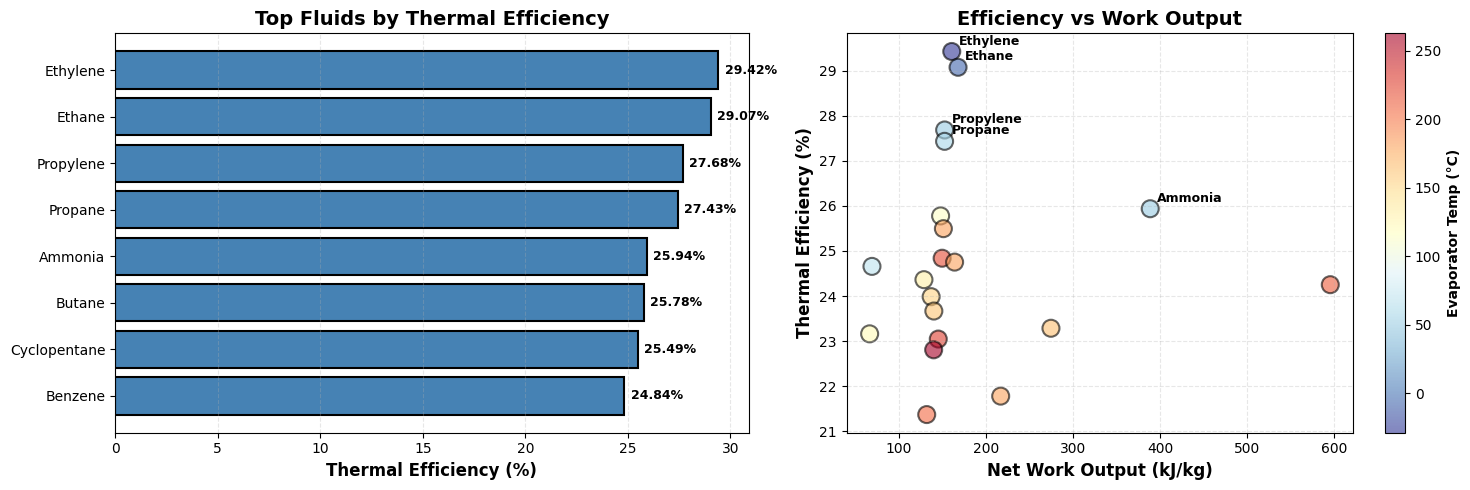


✓ Results exported: orc_screening_results.csv


In [8]:
results_screening = orc_fluid_screening(
    P_evap=20e5,  # 15 bar
    P_cond=0.5e5,   # 1 bar
    top_n=8
)
if results_screening is not None:
    results_screening.to_csv('orc_screening_results.csv', index=False)
    print("\n✓ Results exported: orc_screening_results.csv")

In [9]:
def rankine_optimization(fluid_name, T_evap_target, T_cond_target, maxiter=40):
    print("\n" + "╔"+"═"*78+"╗")
    print("║" + " "*16 + "APPLICATION 3: RANKINE CYCLE OPTIMIZATION" + " "*20 + "║")
    print("╚"+"═"*78+"╝")
    print(f"\nFluid: {fluid_name}")
    print(f"Target Temperatures:")
    print(f"  Evaporator:  {T_evap_target:.1f} K ({T_evap_target-273.15:.1f}°C)")
    print(f"  Condenser:   {T_cond_target:.1f} K ({T_cond_target-273.15:.1f}°C)")
    print("="*80)
    try:
        Tc = PropsSI('Tcrit', fluid_name)
        Pc = PropsSI('pcrit', fluid_name)
        print(f"\nFluid Properties:")
        print(f"  Critical Temperature: {Tc:.1f} K ({Tc-273.15:.1f}°C)")
        print(f"  Critical Pressure:    {Pc/1e5:.1f} bar")
    except:
        print(f"✗ ERROR: Cannot get critical properties for {fluid_name}")
        return None
    try:
        P_sat_evap = PropsSI('P', 'T', T_evap_target, 'Q', 0, fluid_name)
        P_sat_cond = PropsSI('P', 'T', T_cond_target, 'Q', 0, fluid_name)
        print(f"\nSaturation Pressures at Target Temperatures:")
        print(f"  P_sat(T_evap_target): {P_sat_evap/1e5:.2f} bar")
        print(f"  P_sat(T_cond_target): {P_sat_cond/1e5:.2f} bar")
    except Exception as e:
        print(f"✗ ERROR: Cannot get saturation pressures at target temperatures: {e}")
        return None
    eval_count = 0
    best_result = {'eta_rankine': -1.0}
    def objective(x):
        nonlocal eval_count, best_result
        P_evap, P_cond = x
        eval_count += 1
        if P_evap <= P_cond:
            return 1e6
        try:
            T_evap_actual = PropsSI('T', 'P', P_evap, 'Q', 0, fluid_name)
            T_cond_actual = PropsSI('T', 'P', P_cond, 'Q', 0, fluid_name)
            T_penalty = (abs(T_evap_actual - T_evap_target) + \
                         abs(T_cond_actual - T_cond_target)) / (T_evap_target - T_cond_target)
        except:
            return 1e6
        result = rankine_cycle_simulation(
            fluid_name=fluid_name,
            P_evap=P_evap,
            P_cond=P_cond,
            verbose=False
        )
        if result is None:
            return 1e6
        eta = result['eta_rankine']
        if eta <= 0 or eta > 0.50 or np.isnan(eta):
            return 1e6
        if eta > best_result['eta_rankine']:
            best_result.update(result)
        return -eta + T_penalty * 0.01
    P_cond_min_val = max(0.05e5, P_sat_cond * 0.01)
    P_cond_max_val = min(P_sat_cond * 1.1, Pc * 0.7)
    P_evap_min_val = max(P_cond_max_val * 1.05, P_sat_evap * 0.5, 1e5)
    P_evap_max_val = min(P_sat_evap * 1.5, Pc * 0.9)
    if P_cond_min_val >= P_cond_max_val:
        P_cond_min_val = P_cond_max_val * 0.1
        if P_cond_min_val < 0.01e5: P_cond_min_val = 0.01e5
    if P_evap_min_val >= P_evap_max_val:
        P_evap_min_val = P_evap_max_val * 0.8 # Take 80% of max as new min
        if P_evap_min_val < P_cond_max_val * 1.01: P_evap_min_val = P_cond_max_val * 1.01 # Ensure it's above P_cond_max_val
    if P_evap_min_val <= P_cond_max_val:
        P_evap_min_val = P_cond_max_val * 1.01 # Ensure at least 1% gap
    bounds = [
        (P_evap_min_val, P_evap_max_val),
        (P_cond_min_val, P_cond_max_val)
    ]
    print(f"\nOptimization Bounds:")
    print(f"  P_evap: {P_evap_min_val/1e5:.2f} - {P_evap_max_val/1e5:.2f} bar")
    print(f"  P_cond: {P_cond_min_val/1e5:.2f} - {P_cond_max_val/1e5:.2f} bar")
    print(f"\nRunning optimization (max {maxiter} iterations)...")
    print("─"*80)
    result_opt = differential_evolution(
        objective,
        bounds=bounds,
        maxiter=maxiter,
        popsize=5,
        atol=1e-5,
        tol=1e-4,
        seed=42,
        disp=False,
        workers=1
    )
    if result_opt.success and best_result['eta_rankine'] > 0:
        P_evap_opt, P_cond_opt = result_opt.x
        print(f"\n{'='*80}")
        print(f"OPTIMIZATION COMPLETED")
        print(f"{'='*80}")
        print(f"\nOptimal Operating Conditions:")
        print(f"  P_evap:  {P_evap_opt/1e5:.2f} bar")
        print(f"  P_cond:  {P_cond_opt/1e5:.2f} bar")
        print(f"  η_max:   {best_result['eta_rankine']*100:.2f}%")
        print(f"\nActual Temperatures:")
        print(f"  T_evap:  {best_result['T_evap_K']:.2f} K ({best_result['T_evap_K']-273.15:.1f}°C)")
        print(f"  T_cond:  {best_result['T_cond_K']:.2f} K ({best_result['T_cond_K']-273.15:.1f}°C)")
        print(f"\nFunction Evaluations: {eval_count}")
        print("="*80)
        print(f"\n\nFINAL OPTIMIZED CYCLE DETAILS:")
        print("─"*80)
        result_final = rankine_cycle_simulation(
            fluid_name=fluid_name,
            P_evap=P_evap_opt,
            P_cond=P_cond_opt,
            verbose=True
        )
        return {
            'fluid': fluid_name,
            'P_evap_bar': P_evap_opt / 1e5,
            'P_cond_bar': P_cond_opt / 1e5,
            'T_evap_K': best_result['T_evap_K'],
            'T_cond_K': best_result['T_cond_K'],
            'eta_opt': best_result['eta_rankine'],
            'w_net_kJ_kg': best_result['w_net_kJ_kg'],
            'evaluations': eval_count
        }
    else:
        print(f"\n✗ Optimization failed")
        return None
print("✓ Optimization function defined")

✓ Optimization function defined


In [ ]:
# Optimize n-Pentane cycle
print("\n")
opt_result_pentane = rankine_optimization(
    fluid_name='Pentane',
    T_evap_target=400,  # 400 K (127°C)
    T_cond_target=300,  # 300 K (27°C)
    maxiter=3
)